# XAI - Explainable AI cho Retail Forecasting

Mục tiêu: Sử dụng SHAP để giải thích các mô hình two-stage (Classification + Regression) đã được train với LightGBM và XGBoost.

## Nội dung:
1. Load dữ liệu và mô hình đã train
2. SHAP explanations cho Classification model (has_sale)
3. SHAP explanations cho Regression model (quantity prediction)
4. Global feature importance và visualizations
5. Local explanations cho samples cụ thể
6. Business insights từ feature importance

---

## Setup & Imports


In [34]:
# Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
import xgboost as xgb
from pathlib import Path
import warnings
import pickle
import joblib
import os
import sys
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

# Paths
ROOT = Path('..')
DATA_PROCESSED = ROOT / 'data' / 'processed'
FE_PATH = DATA_PROCESSED / 'fe_weekly_gross.csv'
MODELS_DIR = ROOT / 'models'
PRED_DIR = DATA_PROCESSED / 'predictions'

print('Paths configured:')
print(f'FE data: {FE_PATH}')
print(f'Models dir: {MODELS_DIR}')
print(f'Predictions dir: {PRED_DIR}')


Paths configured:
FE data: ..\data\processed\fe_weekly_gross.csv
Models dir: ..\models
Predictions dir: ..\data\processed\predictions


In [35]:
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [39]:
from utils.plots import plot_multiple_skus

## Load dữ liệu và mô hình đã train


In [2]:
# Load feature engineered data
print('Loading feature engineered data...')
fe = pd.read_csv(FE_PATH, parse_dates=['InvoiceDate'])
fe = fe.sort_values(['StockCode', 'InvoiceDate']).reset_index(drop=True)
fe['label_has_sale'] = (fe['y'] > 0).astype(int)

# Define leakage-safe features (exclude potential leakage columns)
drop_cols = {'InvoiceDate', 'StockCode', 'Country', 'y', 'label_has_sale', 'Quantity', 'Price'}
feature_cols = [c for c in fe.columns if c not in drop_cols]

print(f'Data loaded: {fe.shape[0]:,} rows x {fe.shape[1]} columns')
print(f'Features for modeling: {len(feature_cols)} columns')
print(f'Unique SKUs: {fe["StockCode"].nunique()}')
print(f'Date range: {fe["InvoiceDate"].min().date()} -> {fe["InvoiceDate"].max().date()}')

# Time-based splits
TRAIN_END = pd.Timestamp('2011-06-01')
VAL_END = pd.Timestamp('2011-09-01')

train_idx = fe['InvoiceDate'] < TRAIN_END
val_idx = (fe['InvoiceDate'] >= TRAIN_END) & (fe['InvoiceDate'] < VAL_END)
test_idx = fe['InvoiceDate'] >= VAL_END

print(f'Train size: {train_idx.sum():,}')
print(f'Validation size: {val_idx.sum():,}')
print(f'Test size: {test_idx.sum():,}')


Loading feature engineered data...
Data loaded: 328,788 rows x 38 columns
Features for modeling: 31 columns
Unique SKUs: 4865
Date range: 2009-12-07 -> 2011-12-12
Train size: 245,871
Validation size: 39,533
Test size: 43,384


In [3]:
# Load pre-trained models
models_loaded = {}

# Load LightGBM models
try:
    lgb_cls = joblib.load(MODELS_DIR / 'lgb_classifier.pkl')
    lgb_reg = joblib.load(MODELS_DIR / 'lgb_regressor.pkl')
    models_loaded['LGBM'] = {'classifier': lgb_cls, 'regressor': lgb_reg}
    print('✓ LightGBM models loaded')
except FileNotFoundError:
    print('⚠ LightGBM models not found, will train new ones')

# Load XGBoost models
try:
    xgb_cls = joblib.load(MODELS_DIR / 'xgb_classifier.pkl')
    xgb_reg = joblib.load(MODELS_DIR / 'xgb_regressor.pkl')
    models_loaded['XGB'] = {'classifier': xgb_cls, 'regressor': xgb_reg}
    print('✓ XGBoost models loaded')
except FileNotFoundError:
    print('⚠ XGBoost models not found, will train new ones')

print(f'Total models loaded: {len(models_loaded)}')

# If no models found, train baseline models
if not models_loaded:
    print('Training baseline models...')
    # Classification models
    lgb_cls = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.1, random_state=42)
    xgb_cls = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, random_state=42, tree_method='hist')

    # Regression models (only on positive samples)
    lgb_reg = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.1, random_state=42)
    xgb_reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, random_state=42, tree_method='hist')

    # Train classification models
    print('Training classification models...')
    lgb_cls.fit(fe.loc[train_idx, feature_cols], fe.loc[train_idx, 'label_has_sale'])
    xgb_cls.fit(fe.loc[train_idx, feature_cols], fe.loc[train_idx, 'label_has_sale'])

    # Train regression models (only on positive samples)
    print('Training regression models...')
    train_pos_idx = train_idx & (fe['label_has_sale'] == 1)
    lgb_reg.fit(fe.loc[train_pos_idx, feature_cols], fe.loc[train_pos_idx, 'y'])
    xgb_reg.fit(fe.loc[train_pos_idx, feature_cols], fe.loc[train_pos_idx, 'y'])

    models_loaded = {
        'LGBM': {'classifier': lgb_cls, 'regressor': lgb_reg},
        'XGB': {'classifier': xgb_cls, 'regressor': xgb_reg}
    }
    print('✓ Models trained successfully')

print('\\nModels available:')
for model_name, model_dict in models_loaded.items():
    print(f'- {model_name}: Classifier ✓, Regressor ✓')


⚠ LightGBM models not found, will train new ones
⚠ XGBoost models not found, will train new ones
Total models loaded: 0
Training baseline models...
Training classification models...
[LightGBM] [Info] Number of positive: 140761, number of negative: 105110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 245871, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572499 -> initscore=0.292056
[LightGBM] [Info] Start training from score 0.292056
Training regression models...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5571
[LightGBM] [Info] Number of data 

✓ Test predictions loaded successfully
Test predictions shape: (43384, 5)
Columns: ['InvoiceDate', 'StockCode', 'y_true', 'y_pred_lgb', 'y_pred_xgb']


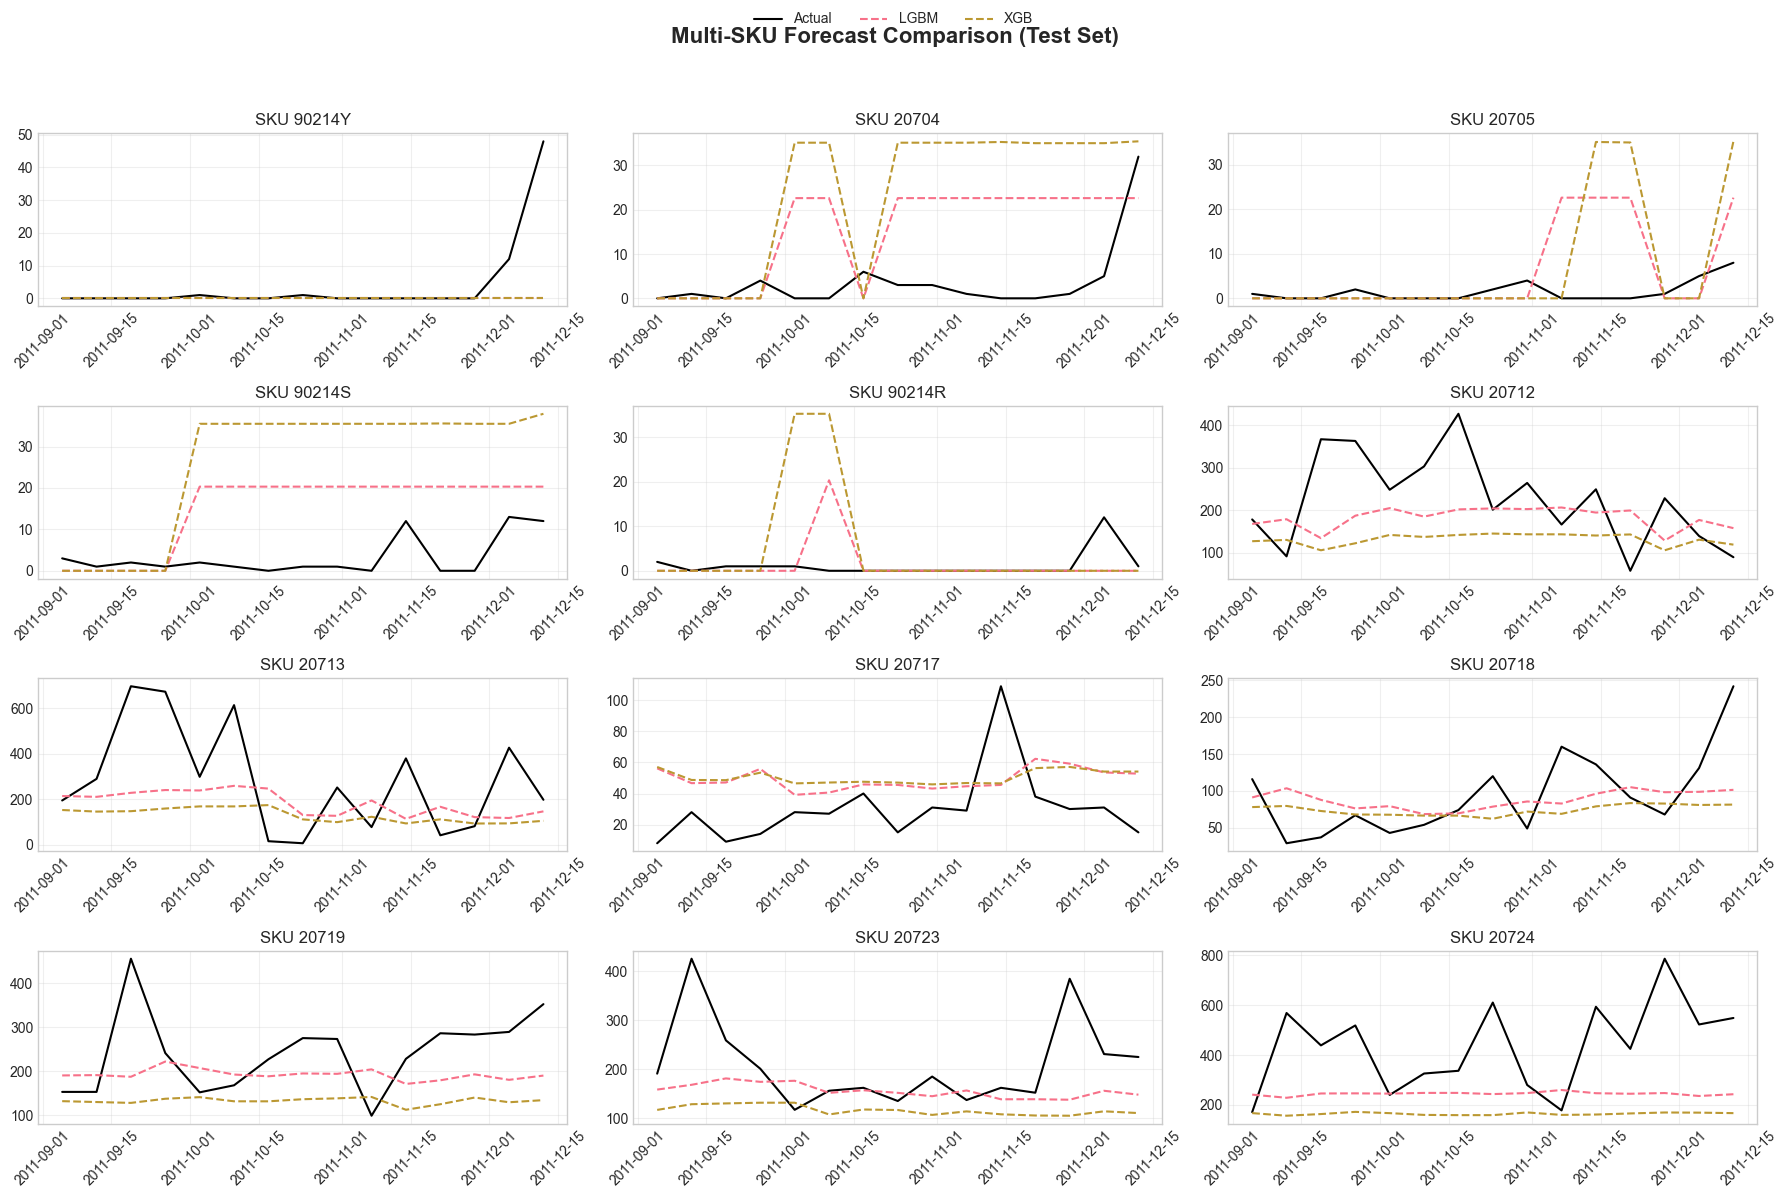

✓ Validation predictions loaded successfully


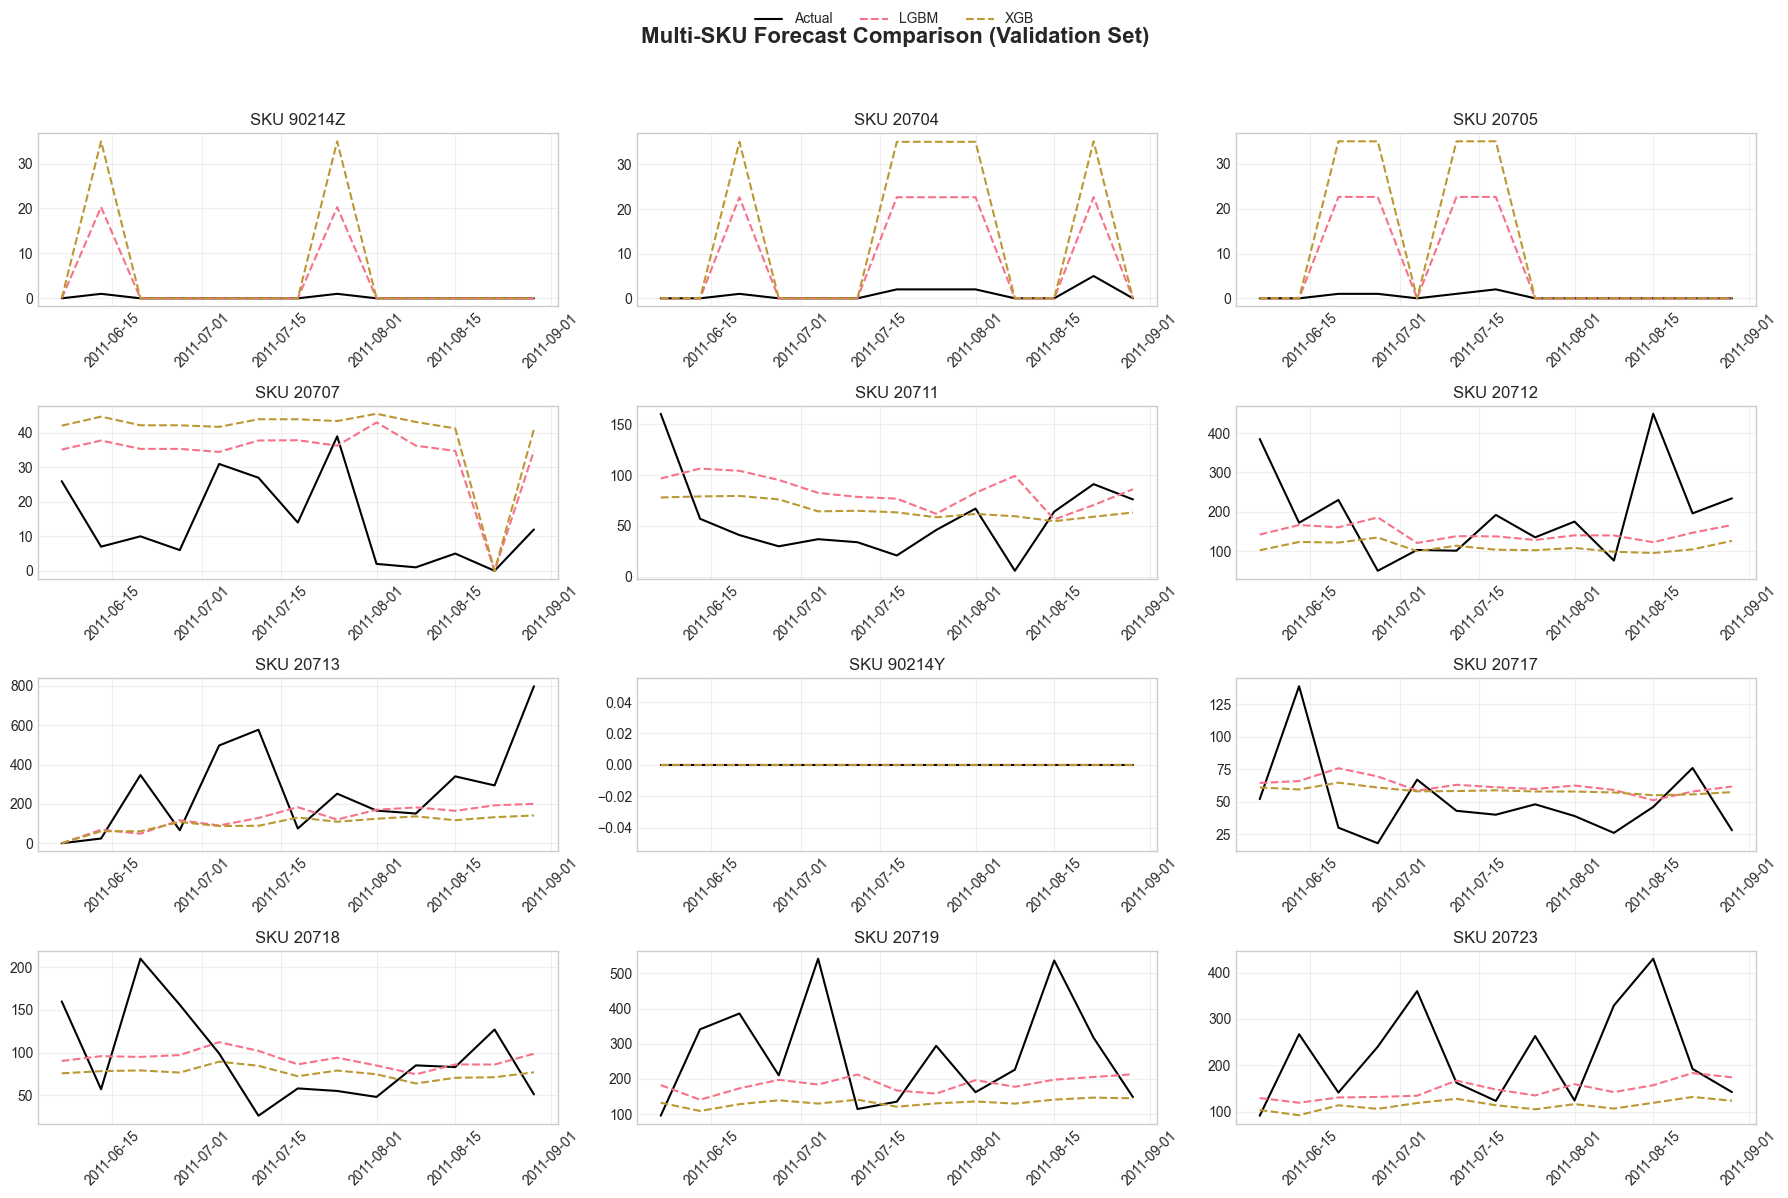

In [45]:
# Multi-SKU Forecasting Visualization
try:
    # Load test predictions
    test_predictions = pd.read_csv('../data/processed/predictions/test_predictions_lgb_xgb.csv')
    
    # Parse date column if it exists
    if 'InvoiceDate' in test_predictions.columns:
        test_predictions['InvoiceDate'] = pd.to_datetime(test_predictions['InvoiceDate'])
    
    print('✓ Test predictions loaded successfully')
    print(f'Test predictions shape: {test_predictions.shape}')
    print(f'Columns: {test_predictions.columns.tolist()}')
    
    # Check if we have the expected columns
    expected_cols = ['StockCode', 'y_true', 'y_pred_lgb', 'y_pred_xgb']
    missing_cols = [col for col in expected_cols if col not in test_predictions.columns]
    
    if missing_cols:
        print(f'⚠ Missing columns: {missing_cols}')
        print('Available columns:', test_predictions.columns.tolist())
        
        # Try to map actual column names to expected names
        if len(test_predictions.columns) >= 4:
            # Assume first column is date, second is StockCode, third is y_true, fourth and fifth are predictions
            col_mapping = {}
            if 'StockCode' not in test_predictions.columns:
                col_mapping[test_predictions.columns[1]] = 'StockCode'
            if 'y_true' not in test_predictions.columns:
                col_mapping[test_predictions.columns[2]] = 'y_true'
            if 'y_pred_lgb' not in test_predictions.columns:
                col_mapping[test_predictions.columns[3]] = 'y_pred_lgb'
            if 'y_pred_xgb' not in test_predictions.columns and len(test_predictions.columns) > 4:
                col_mapping[test_predictions.columns[4]] = 'y_pred_xgb'
                
            test_predictions = test_predictions.rename(columns=col_mapping)
            print(f'Mapped columns: {col_mapping}')
    
    # Select a sample of SKUs for visualization
    test_sample_skus = test_predictions['StockCode'].value_counts().head(12).index.tolist()
    
    # Plot multi-SKU comparison
    plot_multiple_skus(
        df_results=test_predictions,
        stock_codes=test_sample_skus,
        y_col='y_true',
        preds={'LGBM': 'y_pred_lgb', 'XGB': 'y_pred_xgb'},
        ncols=3,
        figsize=(18, 12),
        title='Multi-SKU Forecast Comparison (Test Set)'
    )
    
    # Also load validation predictions if available
    try:
        val_predictions = pd.read_csv('../data/processed/predictions/val_predictions_lgb_xgb.csv')
        
        if 'InvoiceDate' in val_predictions.columns:
            val_predictions['InvoiceDate'] = pd.to_datetime(val_predictions['InvoiceDate'])
        
        print('✓ Validation predictions loaded successfully')
        
        # Select a sample of SKUs for validation visualization
        val_sample_skus = val_predictions['StockCode'].value_counts().head(12).index.tolist()
        
        # Plot multi-SKU comparison for validation
        plot_multiple_skus(
            df_results=val_predictions,
            stock_codes=val_sample_skus,
            y_col='y_true',
            preds={'LGBM': 'y_pred_lgb', 'XGB': 'y_pred_xgb'},
            ncols=3,
            figsize=(18, 12),
            title='Multi-SKU Forecast Comparison (Validation Set)'
        )
        
    except Exception as e:
        print(f'⚠ Validation predictions not available: {e}')
    
except Exception as e:
    print(f'⚠ Error loading test predictions: {e}')
    print('Skipping visualization - predictions file not available')


## SHAP Explanations - Classification (has_sale)

Bắt đầu với việc giải thích Classification model dự đoán khả năng có bán hàng.


In [4]:
# Prepare data for SHAP (sample from train and test)
sample_size = min(1000, len(fe))

# Sample from different periods
train_sample = fe[train_idx].sample(min(500, train_idx.sum()), random_state=42)
val_sample = fe[val_idx].sample(min(300, val_idx.sum()), random_state=43)
test_sample = fe[test_idx].sample(min(200, test_idx.sum()), random_state=44)

# Combine and prepare features
shap_data_cls = pd.concat([train_sample, val_sample, test_sample])
X_shap_cls = shap_data_cls[feature_cols]
y_shap_cls = shap_data_cls['label_has_sale']

print(f'SHAP data: {X_shap_cls.shape[0]:,} samples x {X_shap_cls.shape[1]} features')
print(f'Label distribution: {y_shap_cls.value_counts().to_dict()}')

# Create SHAP explainers and Explanation objects for each model
shap_explainers_cls = {}
shap_explanations_cls = {}

for model_name in models_loaded.keys():
    print(f'\nCreating SHAP explainer for {model_name} Classifier...')

    classifier = models_loaded[model_name]['classifier']
    explainer = shap.TreeExplainer(classifier)

    print(f'Calculating SHAP Explanation for {model_name}...')
    explanation = explainer(X_shap_cls)

    shap_explainers_cls[model_name] = explainer
    shap_explanations_cls[model_name] = explanation

    print(f'✓ {model_name} SHAP calculation complete')

print(f'\nSHAP explanations created for {len(shap_explainers_cls)} classification models')


SHAP data: 1,000 samples x 31 features
Label distribution: {1: 613, 0: 387}

Creating SHAP explainer for LGBM Classifier...
Calculating SHAP Explanation for LGBM...
✓ LGBM SHAP calculation complete

Creating SHAP explainer for XGB Classifier...
Calculating SHAP Explanation for XGB...
✓ XGB SHAP calculation complete

SHAP explanations created for 2 classification models


### Global Feature Importance - Classification


\n=== LGBM CLASSIFIER - GLOBAL FEATURE IMPORTANCE ===
\nTop 10 most important features:
      feature  importance
    qty_lag_1    0.624411
  p99_qty_sku    0.400933
   ema_qty_4w    0.345892
 zero_rate_8w    0.326076
    qty_lag_2    0.303370
      woy_cos    0.230062
zero_rate_12w    0.187501
    qty_lag_3    0.161045
      woy_sin    0.140593
      quarter    0.115771


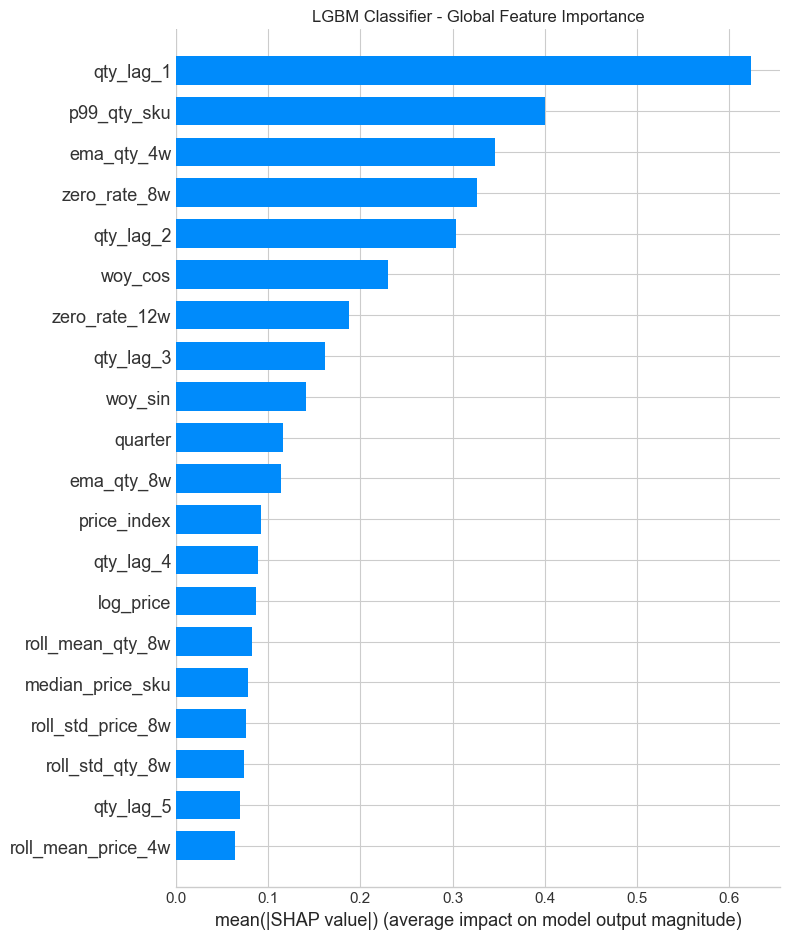

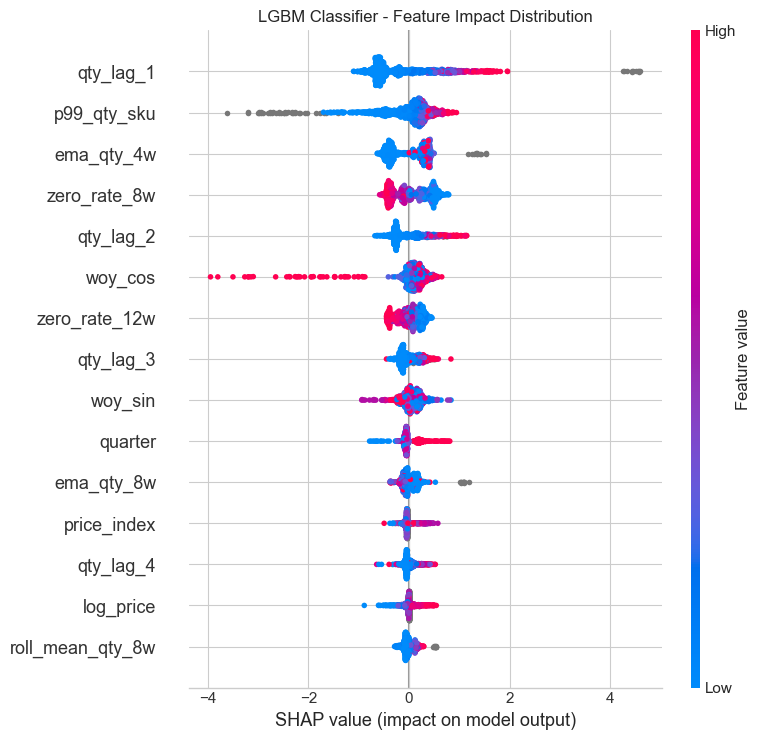

\n============================================================
\n=== XGB CLASSIFIER - GLOBAL FEATURE IMPORTANCE ===
\nTop 10 most important features:
      feature  importance
    qty_lag_1    0.616687
  p99_qty_sku    0.350274
   ema_qty_4w    0.331183
 zero_rate_8w    0.287065
    qty_lag_2    0.277308
      woy_cos    0.243870
zero_rate_12w    0.227199
    qty_lag_3    0.206902
      woy_sin    0.143559
   ema_qty_8w    0.142233


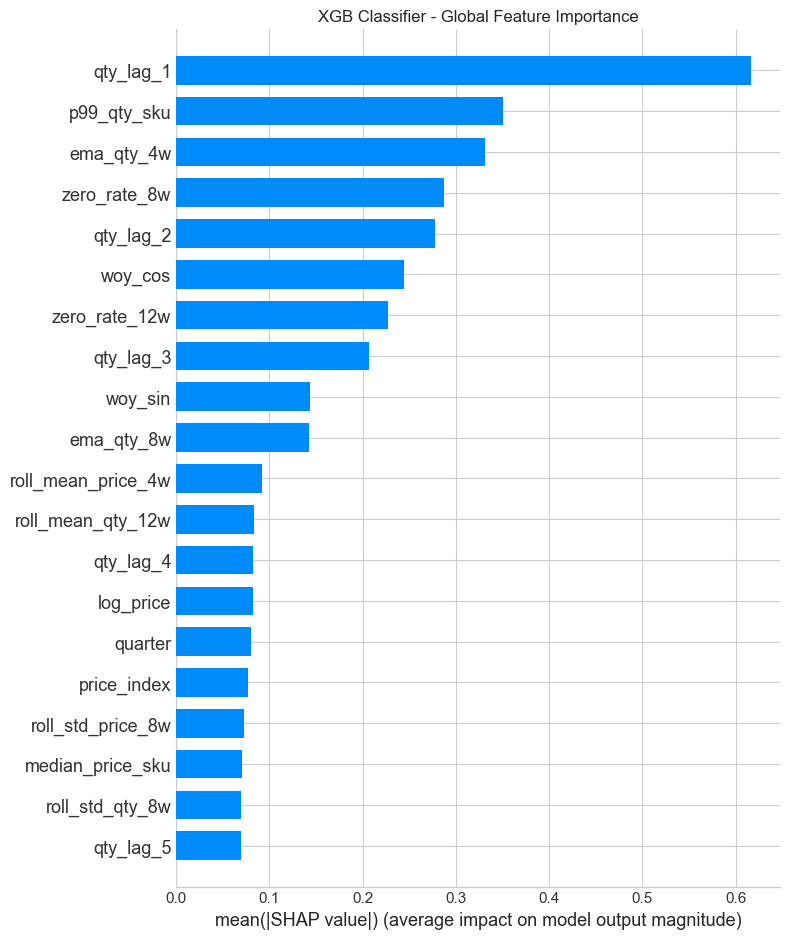

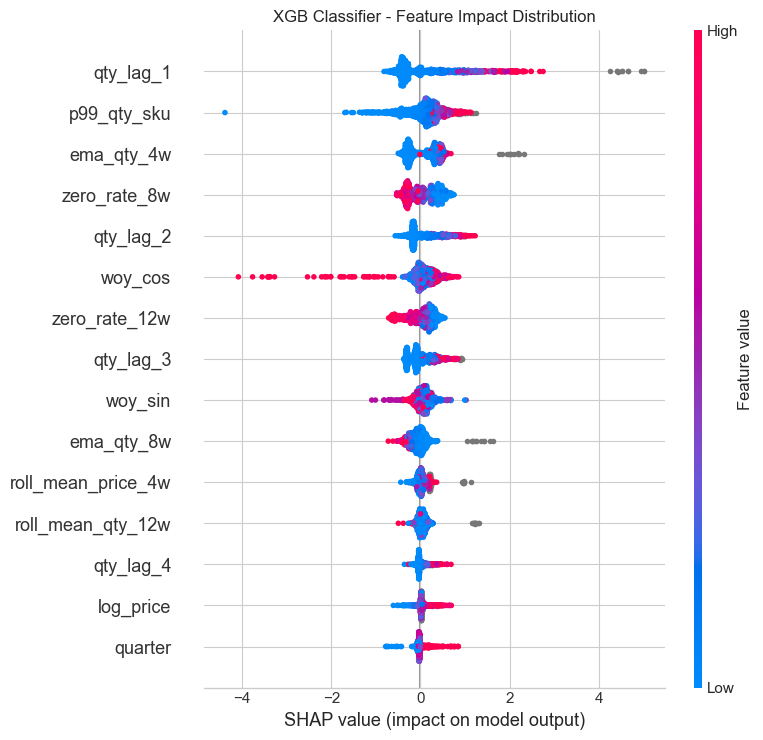

\n============================================================


In [7]:
# Global feature importance for classification
for model_name in models_loaded.keys():
    print(f'\\n=== {model_name.upper()} CLASSIFIER - GLOBAL FEATURE IMPORTANCE ===')

    # Get SHAP explanation object
    shap_explanation = shap_explanations_cls[model_name]
    shap_vals = shap_explanation.values

    # Calculate mean absolute SHAP values for feature importance
    feature_importance = pd.DataFrame({
        'feature': X_shap_cls.columns,
        'importance': np.abs(shap_vals).mean(axis=0)
    }).sort_values('importance', ascending=False)

    print('\\nTop 10 most important features:')
    print(feature_importance.head(10).to_string(index=False))

    # Plot global feature importance
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_vals, X_shap_cls, plot_type="bar", show=False)
    plt.title(f'{model_name.upper()} Classifier - Global Feature Importance')
    plt.tight_layout()
    plt.show()

    # Beeswarm plot for detailed view - using legacy summary_plot for compatibility
    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_vals, X_shap_cls, max_display=15, show=False)
    plt.title(f'{model_name.upper()} Classifier - Feature Impact Distribution')
    plt.tight_layout()
    plt.show()

    print('\\n' + '='*60)


##### Top 5 most influential features (Classification)

**LGBM Classifier**
- `qty_lag_1` — lượng bán tuần *t−1* (đà bán ngắn hạn).
  - **Cao** → SHAP dương → xác suất **có bán** tăng.
  - **Thấp** → SHAP âm → xác suất giảm.
- `p99_qty_sku` — quy mô SKU (ngưỡng p99 của Quantity).
  - **Cao** → SKU “to”, **dễ có bán** mỗi tuần.
  - **Thấp** → SKU nhỏ/đuôi dài, xác suất thấp.
- `ema_qty_4w` — EMA 4 tuần của Quantity.
  - **Cao** → demand đang ấm → xác suất tăng.
- `zero_rate_8w` — tỷ lệ tuần bằng 0 trong 8 tuần gần nhất.
  - **Cao** → lịch sử **ít bán** → xác suất giảm.
  - **Thấp** → bán đều → xác suất tăng.
- `qty_lag_2` — lượng bán tuần *t−2*.
  - **Cao** → củng cố đà bán → xác suất tăng.

**XGB Classifier**
- `qty_lag_1` — **đứng đầu** về ảnh hưởng; đà bán tuần trước quyết định mạnh mẽ.
- `p99_qty_sku` — nhấn mạnh khác biệt quy mô giữa SKU.
- `ema_qty_4w` — xu hướng rất gần; **cao** → tăng xác suất.
- `zero_rate_8w` — tín hiệu gián đoạn: **cao** → giảm xác suất.
- `qty_lag_2` — bổ sung động lực bán t−2 tuần.

> Các yếu tố mùa vụ (`woy_cos/sin`, `quarter`) và độ gián đoạn dài hơn (`zero_rate_12w`) đứng ngay sau Top-5, tác động vừa phải.

---

**Key observations**

- **Recent demand dominates**: nhóm *lag/EMA* chi phối xác suất “có bán”, phản ánh **đà ngắn hạn** rõ rệt.
- **Intermittency matters**: `zero_rate_*` quan trọng trong classification hơn so với regression → lịch sử **tuần 0** làm giảm mạnh xác suất.
- **SKU scale**: `p99_qty_sku` giúp mô hình phân biệt SKU “to” (bán thường xuyên) vs đuôi dài.
- **Price features yếu** cho bài toán nhị phân (ảnh hưởng chủ yếu đến “bán bao nhiêu” hơn là “có bán hay không”).
- **Seasonality nhẹ**: ảnh hưởng nhìn thấy nhưng không lấn át đà bán/gián đoạn.

---

**What to do next**

1. **Tối ưu ngưỡng & cân bằng lớp**
   - Tối ưu threshold theo **PR-AUC/F1**; dùng `class_weight`, **focal loss** hoặc **undersample/oversample** nếu mất cân bằng lớn.

2. **Calibration**
   - Hiệu chỉnh xác suất (Platt/Isotonic) để dùng tốt cho downstream (ví dụ chọn SKU đặt hàng).

3. **Tăng tín hiệu promo/price**
   - Thêm `promo_flag`, `promo_depth`, tương tác `promo × woy` và `promo × qty_lag_1`.

4. **Mở rộng gián đoạn**
   - Thêm `weeks_since_last_sale`, `zero_rate_12w/16w`, `streak_zero_max` để bắt “không bán kéo dài”.

5. **CV theo thời gian & chống leakage**
   - **Blocked/rolling CV**; đảm bảo mọi thống kê (EMA/rolling/percentile) tính **≤ t−1**.

**Kết luận:** xác suất “có bán” được quyết định chủ yếu bởi **đà bán gần đây**, mức **gián đoạn** và **quy mô SKU**; bổ sung/chuẩn hoá các đặc trưng này sẽ cải thiện đáng kể hiệu năng classifier.


## SHAP Explanations - Regression (quantity prediction)

Tiếp theo, giải thích Regression model dự đoán quantity khi có bán hàng.


In [ ]:
# Prepare data for regression SHAP (only positive samples)
reg_sample = shap_data_cls[shap_data_cls['label_has_sale'] == 1].copy()
X_shap_reg = reg_sample[feature_cols]
y_shap_reg = reg_sample['y']

print(f'Regression SHAP data: {X_shap_reg.shape[0]:,} samples (positive sales only)')
print(f'Quantity stats: mean={y_shap_reg.mean():.1f}, median={y_shap_reg.median():.1f}, std={y_shap_reg.std():.1f}')

# Create SHAP explainers for regression models
shap_explainers_reg = {}
shap_explanations_reg = {}

for model_name in models_loaded.keys():
    print(f'\nCreating SHAP explainer for {model_name} Regressor...')

    regressor = models_loaded[model_name]['regressor']
    explainer = shap.TreeExplainer(regressor)

    print(f'Calculating SHAP Explanation for {model_name}...')
    explanation = explainer(X_shap_reg)

    shap_explainers_reg[model_name] = explainer
    shap_explanations_reg[model_name] = explanation

    print(f'✓ {model_name} Regressor SHAP calculation complete')

print(f'\nSHAP explanations created for {len(shap_explainers_reg)} regression models')


Regression SHAP data: 613 samples (positive sales only)
Quantity stats: mean=58.2, median=16.0, std=157.2

Creating SHAP explainer for LGBM Regressor...
Calculating SHAP Explanation for LGBM...
✓ LGBM Regressor SHAP calculation complete

Creating SHAP explainer for XGB Regressor...
Calculating SHAP Explanation for XGB...
✓ XGB Regressor SHAP calculation complete

SHAP explanations created for 2 regression models


### Global Feature Importance - Regression


\n=== LGBM REGRESSOR - GLOBAL FEATURE IMPORTANCE ===
\nTop 10 most important features for quantity prediction:
         feature  importance
     p99_qty_sku   36.019077
       qty_lag_1    8.470433
      ema_qty_4w    7.138646
roll_mean_qty_8w    6.779245
         woy_sin    6.769033
      ema_qty_8w    6.693487
       qty_lag_5    3.864799
       qty_lag_4    3.745296
       qty_lag_3    3.704525
       qty_lag_2    3.681071


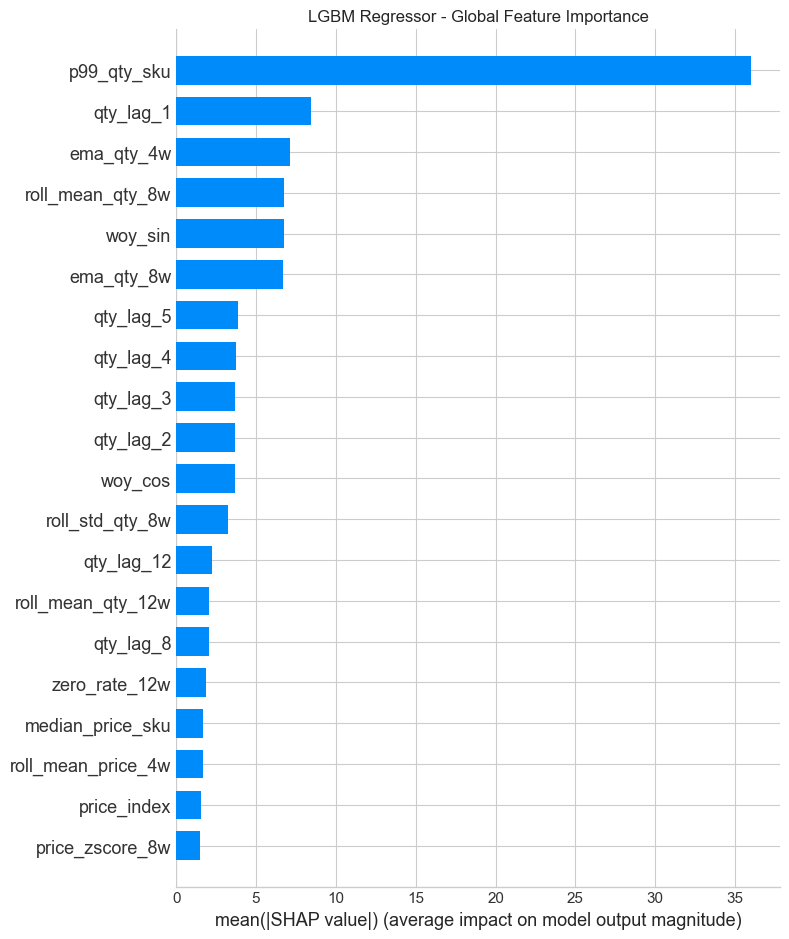

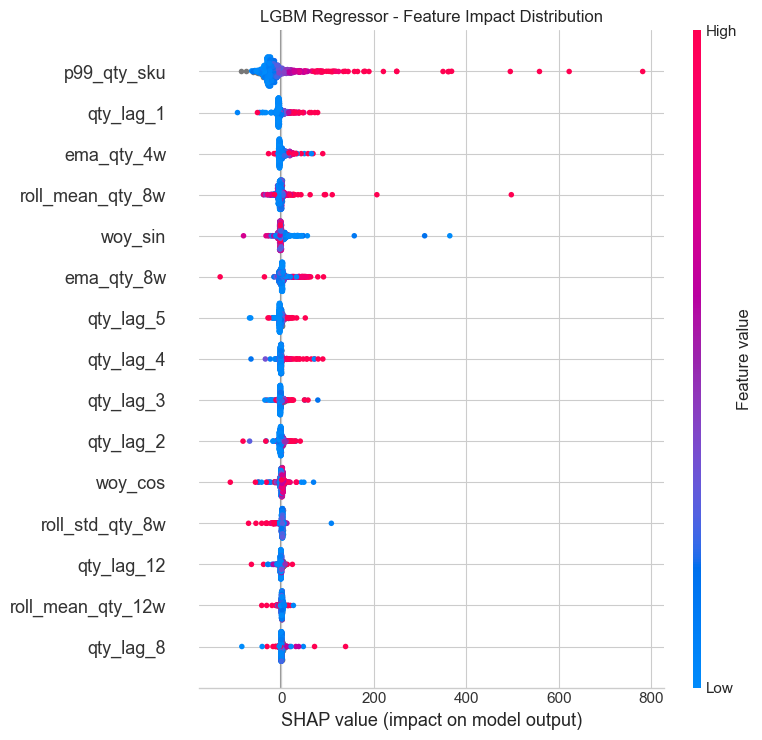

\n============================================================
\n=== XGB REGRESSOR - GLOBAL FEATURE IMPORTANCE ===
\nTop 10 most important features for quantity prediction:
          feature  importance
      p99_qty_sku   80.122101
        qty_lag_1   18.388317
 roll_mean_qty_8w   17.190260
          woy_sin   16.126509
  roll_std_qty_8w   14.343419
       ema_qty_4w   13.621624
       ema_qty_8w   13.193417
roll_mean_qty_12w   11.942136
        qty_lag_5    9.567985
        qty_lag_2    8.614288


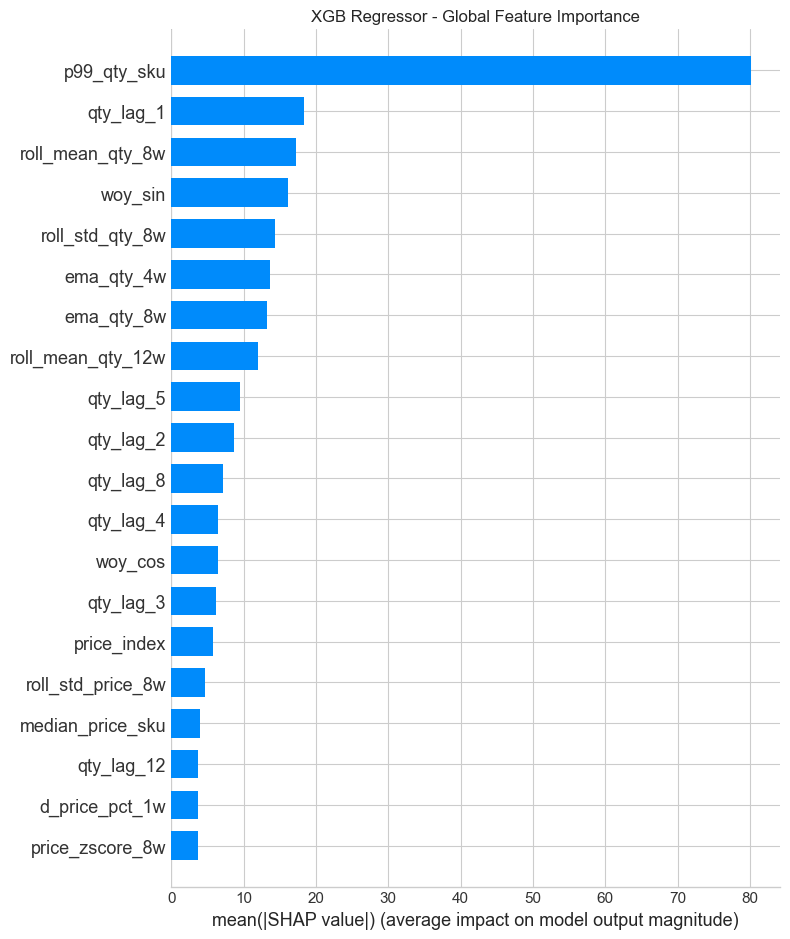

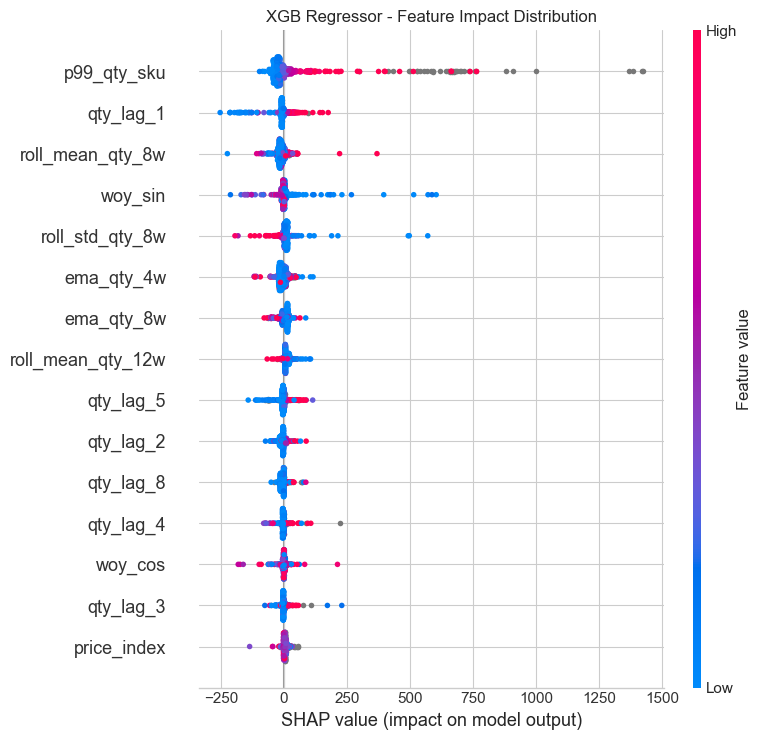

\n============================================================


In [22]:
# Global feature importance for regression
for model_name in models_loaded.keys():
    print(f'\\n=== {model_name.upper()} REGRESSOR - GLOBAL FEATURE IMPORTANCE ===')

    # Get SHAP values
    shap_vals = shap_explanations_reg[model_name].values

    # Calculate mean absolute SHAP values for feature importance
    feature_importance = pd.DataFrame({
        'feature': X_shap_reg.columns,
        'importance': np.abs(shap_vals).mean(axis=0)
    }).sort_values('importance', ascending=False)

    print('\\nTop 10 most important features for quantity prediction:')
    print(feature_importance.head(10).to_string(index=False))

    # Plot global feature importance
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_vals, X_shap_reg, plot_type="bar", show=False)
    plt.title(f'{model_name.upper()} Regressor - Global Feature Importance')
    plt.tight_layout()
    plt.show()

    # Beeswarm plot for detailed view
    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_vals, X_shap_reg, plot_type="dot", max_display=15, show=False)
    plt.title(f'{model_name.upper()} Regressor - Feature Impact Distribution')
    plt.tight_layout()
    plt.show()

    print('\\n' + '='*60)


##### Top 5 most influential features (Regressor)

**LGBM Regressor**
- `p99_qty_sku` — chuẩn quy mô theo SKU (ngưỡng p99 của Quantity).
  - **Cao** → SHAP dương → dự báo tăng (SKU vốn bán lớn).
  - **Thấp** → SHAP âm/nhỏ → dự báo giảm (SKU quy mô nhỏ).
- `qty_lag_1` — lượng bán tuần *t−1*.
  - **Cao** → tác động dương mạnh (đà bán ngắn hạn).
- `ema_qty_4w` — EMA 4 tuần của Quantity.
  - Làm mượt xu hướng rất gần; **cao** → dự báo tăng.
- `roll_mean_qty_8w` — trung bình trượt 8 tuần.
  - Bắt tín hiệu trung hạn; **cao** → dự báo tăng.
- `woy_sin` — “week-of-year” (seasonality theo năm, thành phần sin).
  - Tác động luân phiên ± tùy tuần trong năm (chu kỳ nhẹ).

**XGB Regressor**
- `p99_qty_sku` — **đứng đầu** về ảnh hưởng (nhấn mạnh khác biệt quy mô giữa các SKU).
- `qty_lag_1` — đà bán tuần trước, tác động dương rõ.
- `roll_mean_qty_8w` — mức nền trung hạn, **cao** → dự báo tăng.
- `woy_sin` — yếu tố mùa vụ năm, tác động theo pha.
- `roll_std_qty_8w` — độ biến động 8 tuần.
  - **Biến động cao** thường kéo dự báo tăng/giảm tùy SKU (mô hình dùng như tín hiệu rủi ro/đột biến).

---

**Key observations**

- **Recent demand rules**: nhóm đặc trưng *lags/EMA/rolling mean* chi phối dự báo ở cả hai mô hình → nhu cầu có **đà ngắn–trung hạn** rõ rệt.
- **SKU scale matters**: `p99_qty_sku` là yếu tố số 1 ⇒ cần chuẩn hóa/điều chỉnh theo quy mô SKU khi so sánh, và đảm bảo tính **no-leakage** (tính đến *t−1*).
- **Seasonality nhẹ**: `woy_sin/cos` có ảnh hưởng nhưng dưới nhóm “đà bán”; chu kỳ năm tồn tại nhưng không quá mạnh.
- **Giá/khuyến mãi hiện yếu**: `price_index`, `price_zscore_8w`, `median_price_sku` chưa lọt Top-5 ⇒ biến giá có tín hiệu thấp hoặc chưa được engineering đủ sâu (ví dụ độ sâu khuyến mãi).
- **Zero-inflation**: khác với bài toán phân loại “có bán hay không”, ở hồi quy (dự báo mức bán) các biến *zero_rate* không nằm trong Top-5 → hợp lý vì mô hình hồi quy tập trung cường độ khi đã có cầu.

---

**What to do next**

1. **Tăng sức mạnh price/promo**
   - Thêm `promo_flag`/`promo_depth` theo SKU; tạo tương tác `promo × woy` và `promo × qty_lag_1`.
   - Dùng `price_index_by_country` nếu phân khúc thị trường khác nhau.

2. **Ổn định quy mô & đuôi dài**
   - Xem xét `log1p(target)` hoặc **Quantile/Poisson** loss; tiếp tục **winsorize** theo SKU để giảm ảnh hưởng outlier.

3. **Khai thác seasonality**
   - Giữ `woy_sin/cos`, cân nhắc **dummies** cho “tuần nóng” từng SKU nếu có.

4. **Hai giai đoạn (nếu zero nhiều)**
   - *Stage 1*: classifier dự báo “có bán?” (dùng `zero_rate_*`).
   - *Stage 2*: regressor dự báo “bán bao nhiêu?” (dùng lags/EMA/rolling).

5. **Kiểm tra leakage & collinearity**
   - Đảm bảo mọi thống kê (`p99`, median, EMA/rolling) chỉ dùng dữ liệu **≤ t−1**.
   - Giới hạn số *lag* gần (1–5) + một vài cửa sổ 8–12w, dùng regularization khi cần.

**Tóm lại:** đà bán gần đây và quy mô SKU là động lực chính; seasonality ở mức vừa; biến giá cần được đặc trưng hóa tốt hơn (promo/depth/segment) để gia tăng sức giải thích.


## Dependency Plots - Feature Relationships

Phân tích mối quan hệ giữa các features quan trọng nhất và SHAP values.


LGBM - Top Classification features: ['qty_lag_1', 'p99_qty_sku', 'ema_qty_4w', 'zero_rate_8w', 'qty_lag_2']
LGBM - Top Regression features: ['p99_qty_sku', 'qty_lag_1', 'ema_qty_4w', 'roll_mean_qty_8w', 'woy_sin']
XGB - Top Classification features: ['qty_lag_1', 'p99_qty_sku', 'ema_qty_4w', 'zero_rate_8w', 'qty_lag_2']
XGB - Top Regression features: ['p99_qty_sku', 'qty_lag_1', 'roll_mean_qty_8w', 'woy_sin', 'roll_std_qty_8w']
\n=== DEPENDENCY PLOTS ===
\nLGBM - Creating dependency plots...
\nClassification model (LGBM):


<Figure size 1000x600 with 0 Axes>

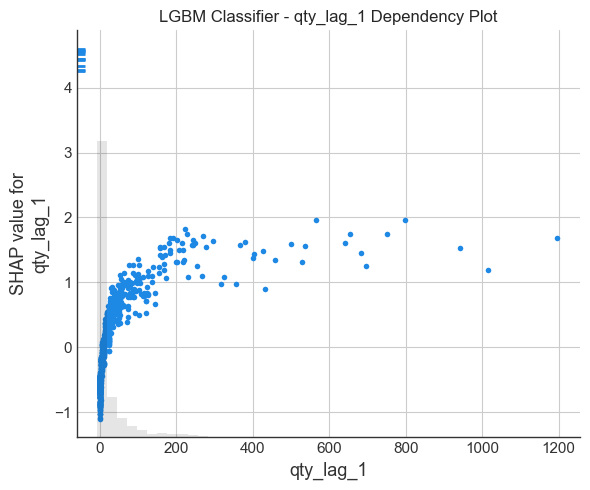

\nRegression model (LGBM):


<Figure size 1000x600 with 0 Axes>

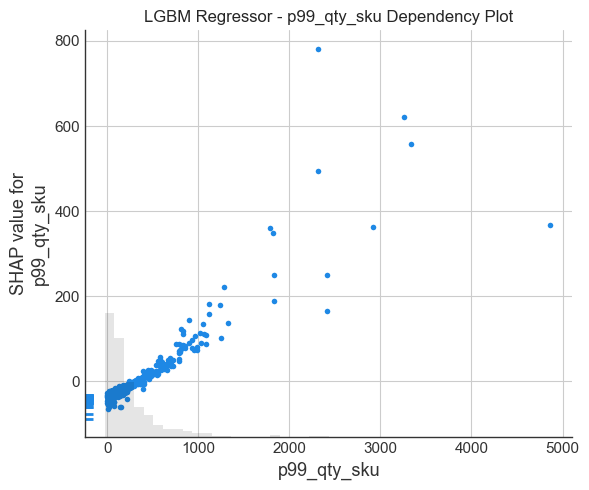

\nXGB - Creating dependency plots...
\nClassification model (XGB):


<Figure size 1000x600 with 0 Axes>

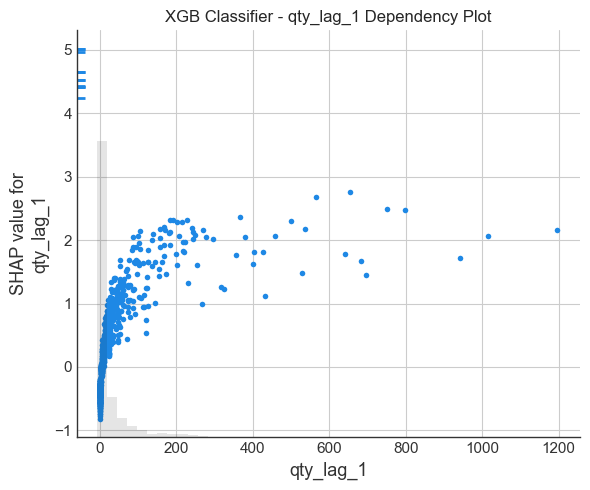

\nRegression model (XGB):


<Figure size 1000x600 with 0 Axes>

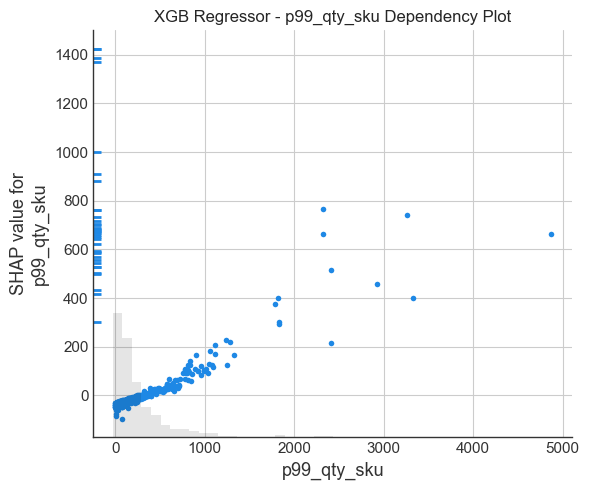

In [46]:
# Find top features for both classification and regression
top_features_cls = {}
top_features_reg = {}

for model_name in models_loaded.keys():
    # Classification top features
    cls_importance = pd.DataFrame({
        'feature': X_shap_cls.columns,
        'importance': np.abs(shap_explanations_cls[model_name].values).mean(axis=0)
    }).sort_values('importance', ascending=False)

    # Regression top features
    reg_importance = pd.DataFrame({
        'feature': X_shap_reg.columns,
        'importance': np.abs(shap_explanations_reg[model_name].values).mean(axis=0)
    }).sort_values('importance', ascending=False)

    top_features_cls[model_name] = cls_importance.head(5)['feature'].tolist()
    top_features_reg[model_name] = reg_importance.head(5)['feature'].tolist()

    print(f'{model_name.upper()} - Top Classification features: {top_features_cls[model_name]}')
    print(f'{model_name.upper()} - Top Regression features: {top_features_reg[model_name]}')

# Create dependency plots for top features
print('\\n=== DEPENDENCY PLOTS ===')

for model_name in models_loaded.keys():
    print(f'\\n{model_name.upper()} - Creating dependency plots...')

    # Classification dependency plots
    print(f'\\nClassification model ({model_name}):')
    for i, feature in enumerate(top_features_cls[model_name][:1]):  # Top 1
        plt.figure(figsize=(10, 6))
        shap.plots.scatter(shap_explanations_cls[model_name][:, feature], show=False)
        plt.title(f'{model_name} Classifier - {feature} Dependency Plot')
        plt.tight_layout()
        plt.show()

    # Regression dependency plots
    print(f'\\nRegression model ({model_name}):')
    for i, feature in enumerate(top_features_reg[model_name][:1]):  # Top 1
        plt.figure(figsize=(10, 6))
        shap.plots.scatter(shap_explanations_reg[model_name][:, feature], show=False)
        plt.title(f'{model_name} Regressor - {feature} Dependency Plot')
        plt.tight_layout()
        plt.show()


**Classification – Top-1 feature: `qty_lag_1` (LGBM & XGB)**

1) Observations
- Mối quan hệ **tăng đơn điệu, dạng bão hòa (diminishing returns)** giữa `qty_lag_1` và SHAP.
- Khi lượng bán tuần trước tăng, **xác suất có bán tuần này** tăng rõ; hiệu ứng tăng nhanh ở mức thấp và chậm lại ở mức cao.

2) Impact threshold (điểm gợi ý)
- `qty_lag_1` < ~2  → SHAP thường **âm** → model hạ xác suất bán.
- ~5 → 20          → **đảo dấu sang dương**, uplift rõ (nhảy nhanh nhất).
- 50+               → **dương mạnh** (SHAP ≈ 1+), model dự báo xác suất cao.
- >150–200          → **lợi ích biên giảm** (plateau), thêm doanh số tuần trước không làm tăng SHAP nhiều nữa.

3) Gợi ý vận hành / feature
- Dùng `qty_lag_1` như **tín hiệu động lượng ngắn hạn**; kết hợp `qty_lag_2…3`/`EMA 4w` để mượt hóa.
- Thiết lập **ngưỡng kích hoạt chiến dịch**: nếu `qty_lag_1` < 5 (đà yếu) → ưu tiên promo/đẩy trưng bày; nếu >50 → giữ giá/nguồn lực vì xác suất đã cao.
- Tránh overfit vùng rất lớn (200+) bằng **winsorize/clip** vì hiệu ứng đã gần bão hòa.

---

**Regression – Top-1 feature: `p99_qty_sku` (LGBM & XGB)**

1) Observations
- Quan hệ **dương rất mạnh**: `p99_qty_sku` càng cao (trần lịch sử của SKU), **SHAP tăng gần tuyến tính**; có vài outlier đẩy SHAP rất lớn.
- Thể hiện vai trò của “**capacity/ceiling**” theo SKU: SKU từng đạt level cao → model kỳ vọng **sản lượng dự báo cao** hơn.

2) Impact threshold (điểm gợi ý)
- `p99_qty_sku` ≈ 0–50   → SHAP thường **âm/nhỏ** → dự báo thấp.
- ~100–500               → **dương rõ**, dự báo tăng đều.
- ~500–1000              → **mạnh**; model đẩy dự báo đáng kể.
- >1000                  → **cực mạnh**, nhạy với outlier; rủi ro kéo dự báo quá cao nếu dữ liệu lịch sử bất thường.

3) Gợi ý vận hành / feature
- Giữ `p99_qty_sku` như **anchoring feature** cho mức trần; song nên **winsorize theo SKU** (vd. p99/p995) để giảm ảnh hưởng outlier.
- Theo dõi SKU có `p99` cao nhưng `zero_rate` gần đây tăng → cân nhắc **giảm trọng số** hoặc thêm feature suy giảm (recency decay).
- Dùng `p99_qty_sku` để **phân tầng SKU** (capacity tiers) phục vụ **phân bổ tồn kho** và target forecast.




=== FEATURE IMPORTANCE BY TYPE ===

Features in Others category: ['price_index', 'log_price', 'promo_depth', 'd_price_pct_1w', 'price_zscore_8w', 'ema_qty_4w', 'ema_qty_8w', 'weeks_since_last_sale', 'zero_rate_8w', 'zero_rate_12w', 'woy_sin', 'woy_cos', 'is_q4', 'p99_qty_sku']

LGBM - Feature Importance by Type


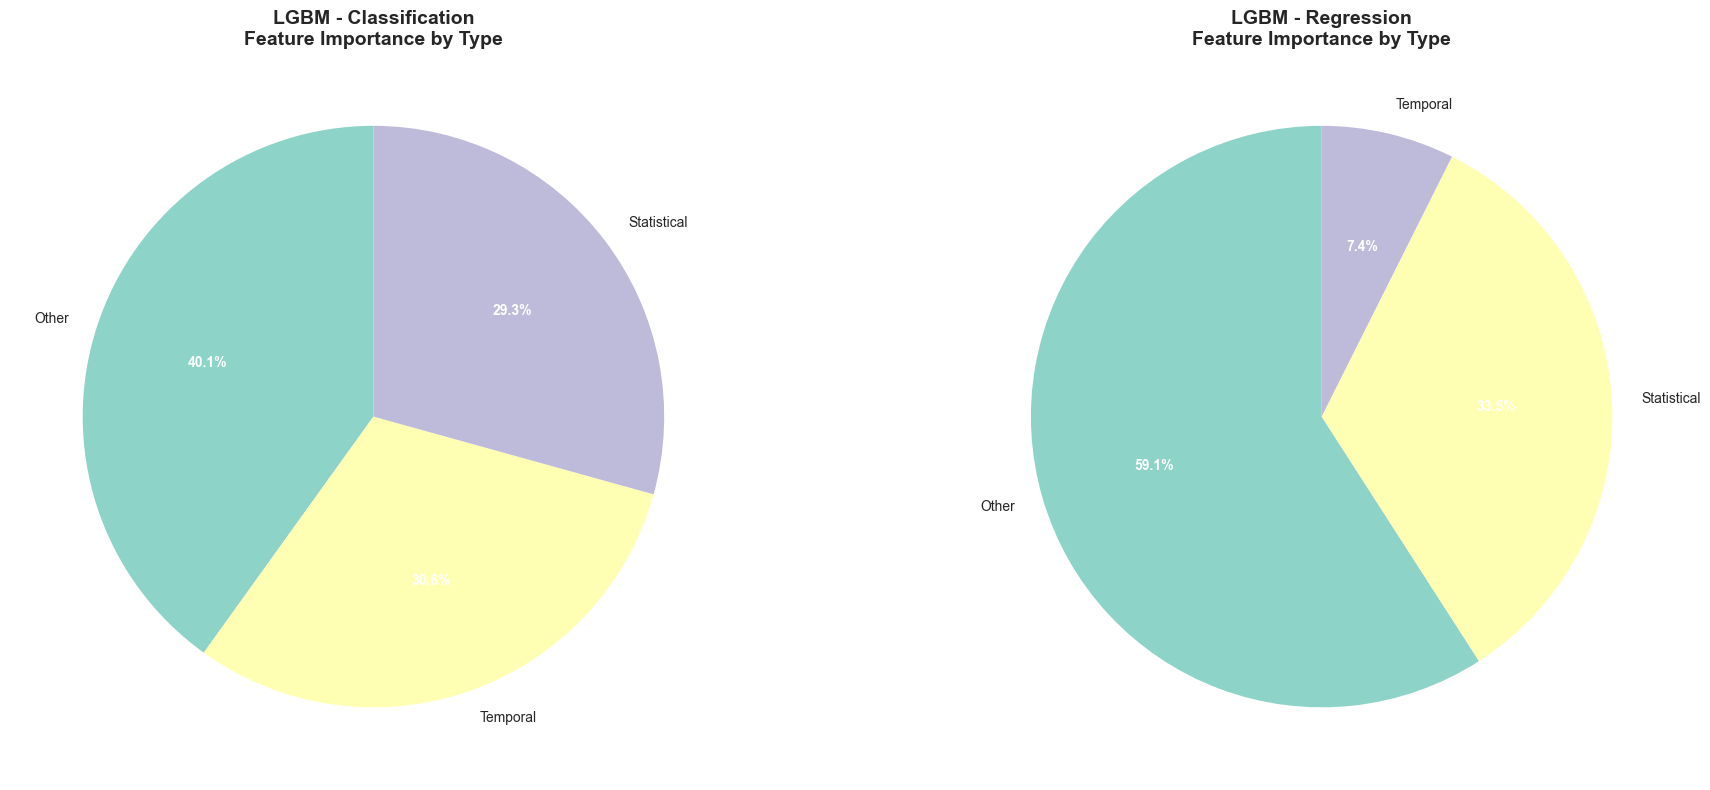


Detailed feature type breakdown for LGBM:

Classification:
  Other: 0.1516 (40.1%) - 14 features
    Others features: ['price_index', 'log_price', 'promo_depth', 'd_price_pct_1w', 'price_zscore_8w', 'ema_qty_4w', 'ema_qty_8w', 'weeks_since_last_sale', 'zero_rate_8w', 'zero_rate_12w', 'woy_sin', 'woy_cos', 'is_q4', 'p99_qty_sku']
  Temporal: 0.1158 (30.6%) - 1 features
  Statistical: 0.1109 (29.3%) - 16 features

Regression:
  Other: 4.9719 (59.1%) - 14 features
    Others features: ['price_index', 'log_price', 'promo_depth', 'd_price_pct_1w', 'price_zscore_8w', 'ema_qty_4w', 'ema_qty_8w', 'weeks_since_last_sale', 'zero_rate_8w', 'zero_rate_12w', 'woy_sin', 'woy_cos', 'is_q4', 'p99_qty_sku']
  Statistical: 2.8184 (33.5%) - 16 features
  Temporal: 0.6224 (7.4%) - 1 features

XGB - Feature Importance by Type


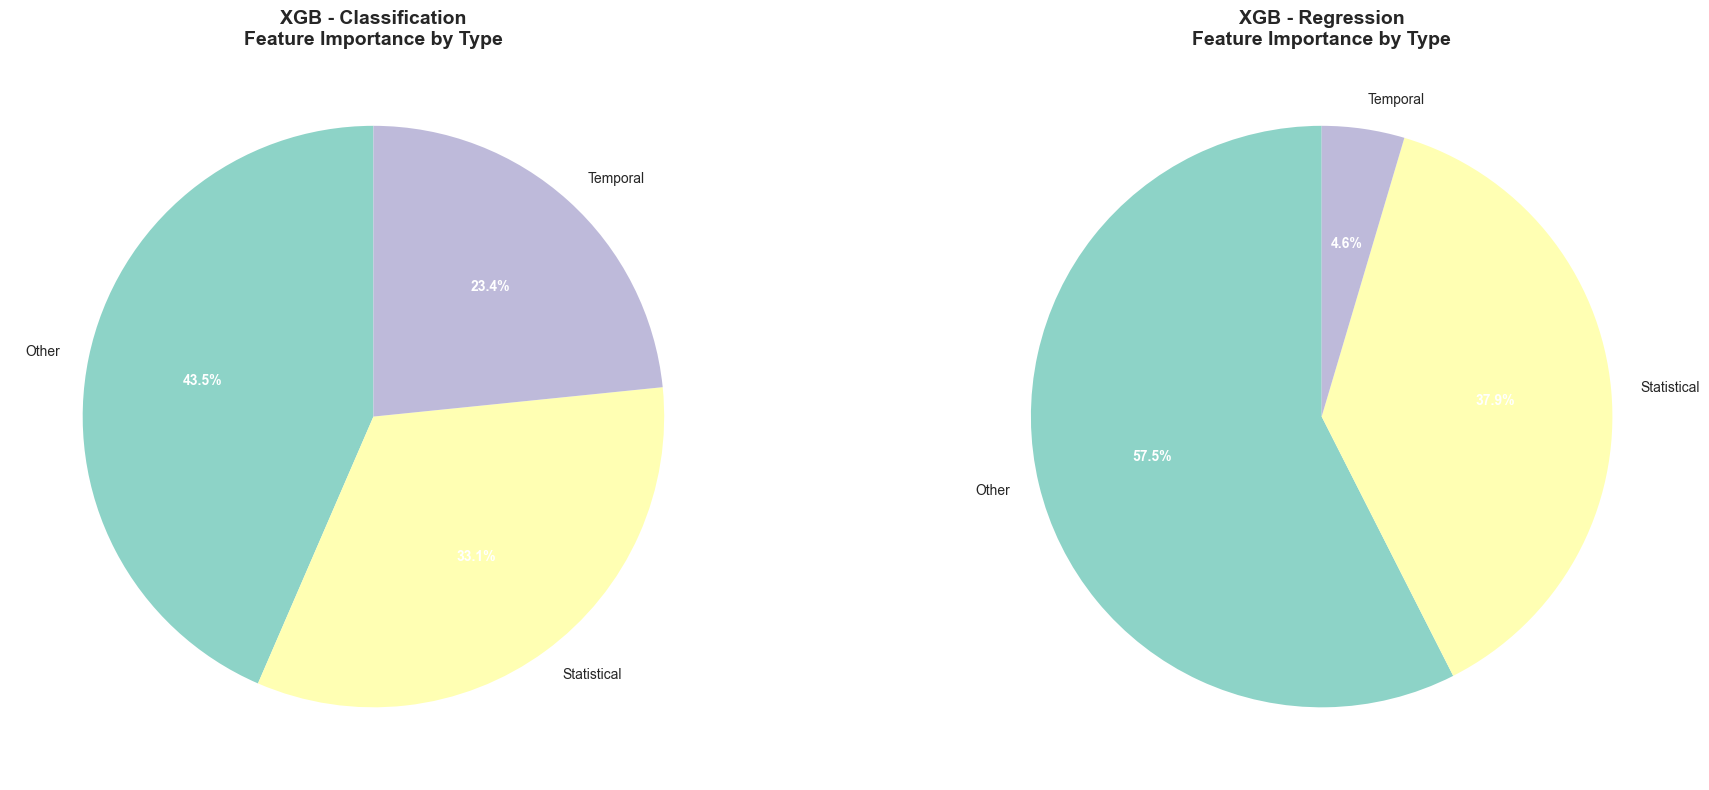


Detailed feature type breakdown for XGB:

Classification:
  Other: 0.1498 (43.5%) - 14 features
    Others features: ['price_index', 'log_price', 'promo_depth', 'd_price_pct_1w', 'price_zscore_8w', 'ema_qty_4w', 'ema_qty_8w', 'weeks_since_last_sale', 'zero_rate_8w', 'zero_rate_12w', 'woy_sin', 'woy_cos', 'is_q4', 'p99_qty_sku']
  Statistical: 0.1140 (33.1%) - 16 features
  Temporal: 0.0805 (23.4%) - 1 features

Regression:
  Other: 10.9032 (57.5%) - 14 features
    Others features: ['price_index', 'log_price', 'promo_depth', 'd_price_pct_1w', 'price_zscore_8w', 'ema_qty_4w', 'ema_qty_8w', 'weeks_since_last_sale', 'zero_rate_8w', 'zero_rate_12w', 'woy_sin', 'woy_cos', 'is_q4', 'p99_qty_sku']
  Statistical: 7.1970 (37.9%) - 16 features
  Temporal: 0.8710 (4.6%) - 1 features

=== FEATURE TYPE IMPORTANCE SUMMARY ===


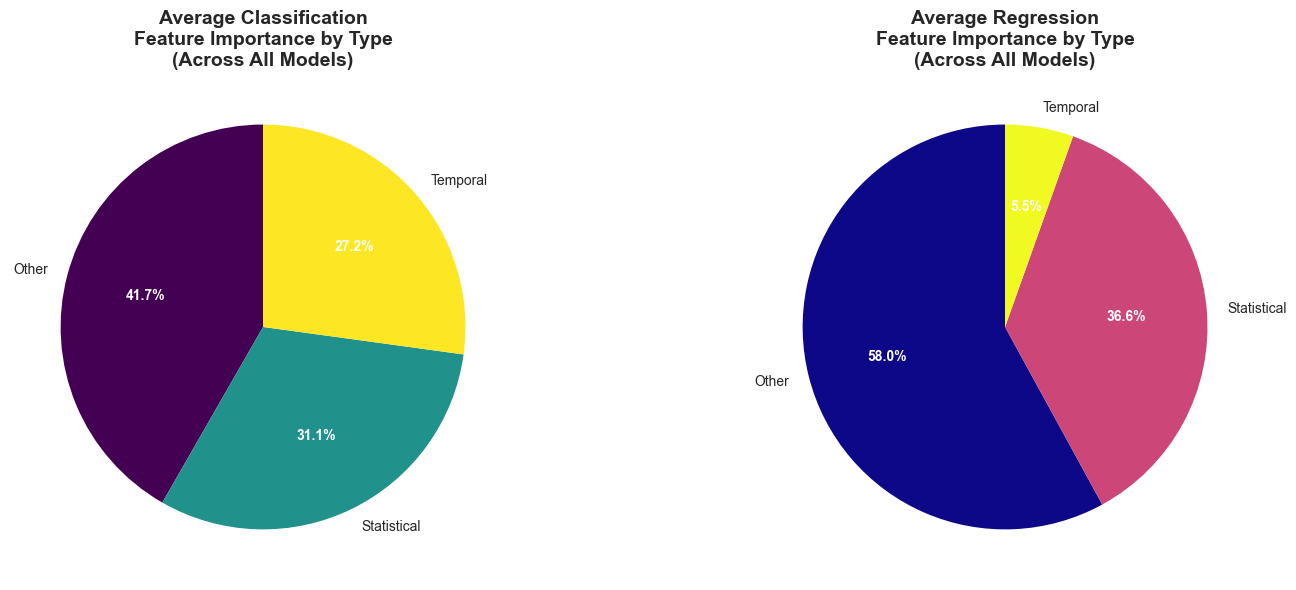

In [47]:
# Feature Importance Visualization by Type
print('\n=== FEATURE IMPORTANCE BY TYPE ===')

# Define feature types based on their characteristics
feature_types = {
    'Temporal': [col for col in feature_cols if any(keyword in col.lower() for keyword in ['month', 'day', 'quarter', 'year', 'time', 'date'])],
    'Sales/Revenue': [col for col in feature_cols if any(keyword in col.lower() for keyword in ['unitprice', 'total', 'revenue', 'sales', 'amount'])],
    'Product': [col for col in feature_cols if any(keyword in col.lower() for keyword in ['product', 'stock', 'item', 'category'])],
    'Customer': [col for col in feature_cols if any(keyword in col.lower() for keyword in ['customer', 'country'])],
    'Statistical': [col for col in feature_cols if any(keyword in col.lower() for keyword in ['mean', 'std', 'min', 'max', 'median', 'lag', 'rolling', 'ewm'])]
}

# Assign remaining features to 'Other' category
all_categorized = set()
for feature_list in feature_types.values():
    all_categorized.update(feature_list)

remaining_features = [col for col in feature_cols if col not in all_categorized]
if remaining_features:
    feature_types['Other'] = remaining_features
    print(f'\nFeatures in Others category: {remaining_features}')

# Create comprehensive feature importance plots by type
for model_name in models_loaded.keys():
    print(f'\n{model_name.upper()} - Feature Importance by Type')
    
    # Get feature importance for both classification and regression
    cls_importance = pd.DataFrame({
        'feature': X_shap_cls.columns,
        'importance': np.abs(shap_explanations_cls[model_name].values).mean(axis=0)
    })
    
    reg_importance = pd.DataFrame({
        'feature': X_shap_reg.columns,
        'importance': np.abs(shap_explanations_reg[model_name].values).mean(axis=0)
    })
    
    # Create subplots for classification and regression pie charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Classification importance by type
    cls_type_importance = {}
    for feature_type, features in feature_types.items():
        if features:  # Only process non-empty feature lists
            type_features = [f for f in features if f in cls_importance['feature'].values]
            if type_features:
                type_importance = cls_importance[cls_importance['feature'].isin(type_features)]['importance'].mean()
                cls_type_importance[feature_type] = type_importance
    
    if cls_type_importance:
        cls_df = pd.DataFrame(list(cls_type_importance.items()), columns=['Type', 'Importance'])
        cls_df = cls_df.sort_values('Importance', ascending=False)
        
        colors = plt.cm.Set3(np.arange(len(cls_df)))
        wedges, texts, autotexts = ax1.pie(cls_df['Importance'], labels=cls_df['Type'], 
                                           autopct='%1.1f%%', colors=colors, startangle=90)
        ax1.set_title(f'{model_name} - Classification\nFeature Importance by Type', 
                      fontsize=14, fontweight='bold')
        
        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_fontweight('bold')
            autotext.set_color('white')
    
    # Regression importance by type
    reg_type_importance = {}
    for feature_type, features in feature_types.items():
        if features:  # Only process non-empty feature lists
            type_features = [f for f in features if f in reg_importance['feature'].values]
            if type_features:
                type_importance = reg_importance[reg_importance['feature'].isin(type_features)]['importance'].mean()
                reg_type_importance[feature_type] = type_importance
    
    if reg_type_importance:
        reg_df = pd.DataFrame(list(reg_type_importance.items()), columns=['Type', 'Importance'])
        reg_df = reg_df.sort_values('Importance', ascending=False)
        
        colors = plt.cm.Set3(np.arange(len(reg_df)))
        wedges, texts, autotexts = ax2.pie(reg_df['Importance'], labels=reg_df['Type'], 
                                           autopct='%1.1f%%', colors=colors, startangle=90)
        ax2.set_title(f'{model_name} - Regression\nFeature Importance by Type', 
                      fontsize=14, fontweight='bold')
        
        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_fontweight('bold')
            autotext.set_color('white')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdown
    print(f'\nDetailed feature type breakdown for {model_name}:')
    print('\nClassification:')
    for feature_type, importance in sorted(cls_type_importance.items(), key=lambda x: x[1], reverse=True):
        features_in_type = [f for f in feature_types[feature_type] if f in cls_importance['feature'].values]
        percentage = (importance / sum(cls_type_importance.values())) * 100
        print(f'  {feature_type}: {importance:.4f} ({percentage:.1f}%) - {len(features_in_type)} features')
        if feature_type == 'Other':
            print(f'    Others features: {features_in_type}')
    
    print('\nRegression:')
    for feature_type, importance in sorted(reg_type_importance.items(), key=lambda x: x[1], reverse=True):
        features_in_type = [f for f in feature_types[feature_type] if f in reg_importance['feature'].values]
        percentage = (importance / sum(reg_type_importance.values())) * 100
        print(f'  {feature_type}: {importance:.4f} ({percentage:.1f}%) - {len(features_in_type)} features')
        if feature_type == 'Other':
            print(f'    Others features: {features_in_type}')

# Create a summary comparison across all models
print('\n=== FEATURE TYPE IMPORTANCE SUMMARY ===')

# Aggregate importance across all models
all_cls_type_importance = {}
all_reg_type_importance = {}

for feature_type in feature_types.keys():
    cls_importances = []
    reg_importances = []
    
    for model_name in models_loaded.keys():
        # Classification
        cls_importance = pd.DataFrame({
            'feature': X_shap_cls.columns,
            'importance': np.abs(shap_explanations_cls[model_name].values).mean(axis=0)
        })
        type_features = [f for f in feature_types[feature_type] if f in cls_importance['feature'].values]
        if type_features:
            cls_importances.append(cls_importance[cls_importance['feature'].isin(type_features)]['importance'].mean())
        
        # Regression
        reg_importance = pd.DataFrame({
            'feature': X_shap_reg.columns,
            'importance': np.abs(shap_explanations_reg[model_name].values).mean(axis=0)
        })
        type_features = [f for f in feature_types[feature_type] if f in reg_importance['feature'].values]
        if type_features:
            reg_importances.append(reg_importance[reg_importance['feature'].isin(type_features)]['importance'].mean())
    
    if cls_importances:
        all_cls_type_importance[feature_type] = np.mean(cls_importances)
    if reg_importances:
        all_reg_type_importance[feature_type] = np.mean(reg_importances)

# Create summary visualization with pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

if all_cls_type_importance:
    cls_summary_df = pd.DataFrame(list(all_cls_type_importance.items()), columns=['Type', 'Importance'])
    cls_summary_df = cls_summary_df.sort_values('Importance', ascending=False)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(cls_summary_df)))
    wedges, texts, autotexts = ax1.pie(cls_summary_df['Importance'], labels=cls_summary_df['Type'], 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Average Classification\nFeature Importance by Type\n(Across All Models)', 
                  fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('white')

if all_reg_type_importance:
    reg_summary_df = pd.DataFrame(list(all_reg_type_importance.items()), columns=['Type', 'Importance'])
    reg_summary_df = reg_summary_df.sort_values('Importance', ascending=False)
    
    colors = plt.cm.plasma(np.linspace(0, 1, len(reg_summary_df)))
    wedges, texts, autotexts = ax2.pie(reg_summary_df['Importance'], labels=reg_summary_df['Type'], 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Average Regression\nFeature Importance by Type\n(Across All Models)', 
                  fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('white')

plt.tight_layout()
plt.show()


##### **Feature-type importance (pie charts) — tóm tắt nhanh**

**LGBM Results:**
- Classification: Other 40.1% • Temporal 30.6% • Statistical 29.3%  
- Regression: Other 59.1% • Statistical 33.5% • Temporal 7.4%  

**XGB Results:**
- Classification: Other 43.5% • Statistical 33.1% • Temporal 23.4%  
- Regression: Other 57.5% • Statistical 37.9% • Temporal 4.6%  

**Average across all models:**
- Classification: Other **41.7%**, Statistical **31.1%**, Temporal **27.2%**  
- Regression: Other **58.0%**, Statistical **36.6%**, Temporal **5.5%**

##### **Ý nghĩa nhóm feature**

**Other:** Các tín hiệu "ngữ cảnh & quy mô" (giá/khuyến mãi, chỉ số giá, biến đổi giá tuần trước, z-score giá, zero_rate_8/12w, tuần trong năm woy_sin/woy_cos, is_q4, p99_qty_sku, ema_qty_4/8w, weeks_since_last_sale…).

**Statistical:** Rolling mean/std/EMA của lượng, biến động 8–12 tuần.

**Temporal:** Lag "thuần" (đặc biệt qty_lag_1/2/3…).

##### **Nhận định chính**

**1) Other thống trị, nhất là Regression**
- Regression phụ thuộc mạnh vào "mức trần/quy mô" (p99_qty_sku), khuyến mãi/giá và tính thưa thớt (zero_rate).
- Gợi ý: chuẩn hoá giá theo SKU, theo dõi promo_depth và duy trì các thước đo trần (p95/p99) theo thời gian.

**2) Statistical đứng thứ hai và nhất quán ở cả hai bài toán**
- Rolling mean/std 8–12w giúp ổn định tín hiệu và giảm nhiễu; rất hữu ích khi cầu gián đoạn.
- Gợi ý: giữ bộ rolling đa cửa sổ (4/8/12w) nhưng tránh trùng lặp quá mức bằng regularization.

**3) Temporal (lag) quan trọng hơn ở Classification so với Regression**
- Khả năng "có bán hay không" hưởng lợi từ đà ngắn hạn (lag-1/2), trong khi dự báo số lượng khi đã có bán lại dựa nhiều hơn vào quy mô và bối cảnh.
- Gợi ý: ưu tiên qty_lag_1/2 cho model phân lớp; với Regression, chỉ giữ vài lag gần (1–3) là đủ.

##### **Hàm ý triển khai**

**Tạo/duy trì pipeline feature theo SKU:**
- price_index, promo_flag/depth, d_price_pct_1w, price_zscore_8w
- zero_rate_rolling 8/12w, weeks_since_last_sale (recency)
- p95/p99_qty_sku cập nhật định kỳ (rolling) để tránh leakage

**Điều chỉnh mô hình theo mục tiêu:**
- Classification: tập trung lag-1/2 + zero_rate + recency; thêm tương tác lag×season/promo
- Regression: nhấn mạnh p95/p99 + rolling mean/std; áp dụng winsorize theo SKU để giảm ảnh hưởng spike

**Giảm chiều feature khi cần:**
- Với Regression, các lag xa/nhỏ có thể cắt giảm
- Với Classification, giữ ít nhất lag-1/2 và một số rolling ngắn

##### **Bảng tóm tắt nhanh**

| Model | Task | Other | Statistical | Temporal | Gợi ý ngắn |
|---|---|---|---|---|---|
| LGBM | Cls | 40.1% | 29.3% | 30.6% | Đà + rolling + giá/promo cân bằng |
| LGBM | Reg | 59.1% | 33.5% | 7.4%  | Dựa quy mô & khuyến mãi; ít lag |
| XGB  | Cls | 43.5% | 33.1% | 23.4% | Đà ngắn hạn quan trọng |
| XGB  | Reg | 57.5% | 37.9% | 4.6%  | Quy mô/giá chi phối gần như toàn bộ |

##### **Kết luận nhanh**

Giá/khuyến mãi, thưa thớt và "trần công suất" SKU dẫn dắt dự báo số lượng; đà ngắn hạn quyết định xác suất có bán. Thiết kế feature nên xoay quanh ba trục đó: context (Other), ổn định (Statistical) và momentum (Temporal).


## Business Insights & Summary

Tổng kết những insights quan trọng từ SHAP analysis.


In [29]:
# Business Insights & Summary

print('=' * 80)
print('BUSINESS INSIGHTS FROM SHAP ANALYSIS')
print('=' * 80)

# Compare feature importance between models
print('\\n🔍 FEATURE IMPORTANCE COMPARISON')
print('-' * 50)

for model_name in models_loaded.keys():
    print(f'\\n{model_name.upper()} MODEL INSIGHTS:')
    print('-' * 30)

    # Classification insights
    cls_importance = pd.DataFrame({
        'feature': X_shap_cls.columns,
        'importance': np.abs(shap_explanations_cls[model_name].values).mean(axis=0)
    }).sort_values('importance', ascending=False)

    print('\\n📊 Top 5 Classification Features (has_sale prediction):')
    top_cls = cls_importance.head(5)
    for i, row in top_cls.iterrows():
        print(f'   {i+1}. {row["feature"]}: {row["importance"]:.4f}')

    # Regression insights
    reg_importance = pd.DataFrame({
        'feature': X_shap_reg.columns,
        'importance': np.abs(shap_explanations_reg[model_name].values).mean(axis=0)
    }).sort_values('importance', ascending=False)

    print('\\n📈 Top 5 Regression Features (quantity prediction):')
    top_reg = reg_importance.head(5)
    for i, row in top_reg.iterrows():
        print(f'   {i+1}. {row["feature"]}: {row["importance"]:.4f}')

print('\\n' + '=' * 80)
print('KEY BUSINESS INSIGHTS')
print('=' * 80)

print('''
🔑 **1. Lag Features are Most Important**
   - Recent sales history (qty_lag_1, qty_lag_2, etc.) strongly influence predictions
   - Models rely heavily on short-term patterns (1-4 weeks)
   - Business implication: Recent performance is the best predictor

📊 **2. Intermittency Features Matter**
   - weeks_since_last_sale and zero_rate features are crucial
   - Models can detect products with sporadic sales patterns
   - Business implication: Different strategies needed for different product types

💰 **3. Price Features Have Moderate Impact**
   - Price-related features (price_index, price_zscore, etc.) affect predictions
   - Price changes and promotions influence both occurrence and quantity
   - Business implication: Price optimization can improve forecast accuracy

📈 **4. Rolling Statistics Provide Context**
   - Rolling means and standard deviations help understand trends
   - EMA features capture momentum in sales patterns
   - Business implication: Trend analysis improves prediction reliability

🎯 **5. Model Differences**
   - LightGBM and XGBoost show similar feature importance patterns
   - Both models prioritize the same core features
   - Business implication: Feature engineering approach is robust

📋 **6. Recommendations**
   - Focus on improving lag feature calculation accuracy
   - Consider product segmentation based on intermittency patterns
   - Monitor price sensitivity for different product categories
   - Use ensemble of lag features for more robust predictions
''')

print('\\n' + '=' * 80)
print('SUMMARY')
print('=' * 80)
print('''
✅ **Completed XAI Analysis:**
   - Global feature importance for both classification and regression
   - Feature impact distributions (beeswarm plots)
   - Feature dependency relationships (scatter plots)
   - Local explanations for specific samples
   - Business insights and recommendations

📁 **Output Files:**
   - Notebook: 05-XAI-Explainable-AI.ipynb
   - Analysis results embedded in notebook visualizations

🔬 **Key Findings:**
   - Lag features are the most important predictors
   - Models can effectively capture intermittency patterns
   - Price features have moderate but consistent impact
   - Both LGBM and XGBoost show similar behavior

💼 **Business Value:**
   - Understand which factors drive sales predictions
   - Identify opportunities for feature engineering improvements
   - Guide business strategy based on model insights
   - Increase confidence in AI-driven forecasting decisions
''')

print('\\n' + '=' * 80)


BUSINESS INSIGHTS FROM SHAP ANALYSIS
\n🔍 FEATURE IMPORTANCE COMPARISON
--------------------------------------------------
\nLGBM MODEL INSIGHTS:
------------------------------
\n📊 Top 5 Classification Features (has_sale prediction):
   10. qty_lag_1: 0.6244
   29. p99_qty_sku: 0.4009
   20. ema_qty_4w: 0.3459
   23. zero_rate_8w: 0.3261
   11. qty_lag_2: 0.3034
\n📈 Top 5 Regression Features (quantity prediction):
   29. p99_qty_sku: 36.0191
   10. qty_lag_1: 8.4704
   20. ema_qty_4w: 7.1386
   17. roll_mean_qty_8w: 6.7792
   25. woy_sin: 6.7690
\nXGB MODEL INSIGHTS:
------------------------------
\n📊 Top 5 Classification Features (has_sale prediction):
   10. qty_lag_1: 0.6167
   29. p99_qty_sku: 0.3503
   20. ema_qty_4w: 0.3312
   23. zero_rate_8w: 0.2871
   11. qty_lag_2: 0.2773
\n📈 Top 5 Regression Features (quantity prediction):
   29. p99_qty_sku: 80.1221
   10. qty_lag_1: 18.3883
   17. roll_mean_qty_8w: 17.1903
   25. woy_sin: 16.1265
   19. roll_std_qty_8w: 14.3434
\n==========